In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold._t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import math

In [3]:
#data manipulation before training

def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

def euclidean_distance(x1, x2):
    distance = 0
    for i in range(len(x1)):
        distance += pow((x1[i] - x2[i]), 2)
    return math.sqrt(distance)

def calculate_covariance_matrix(X, Y=None):
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)

In [4]:
class KMeans():

    def __init__(self, k=2, max_iterations=2000):
        self.k = k
        self.max_iterations = max_iterations

    def _init_random_centroids(self, X):
        n_samples, n_features = np.shape(X)
        centroids = np.zeros((self.k, n_features))
        for i in range(self.k):
            centroid = X[np.random.choice(range(n_samples))]
            centroids[i] = centroid
        return centroids

    def _closest_centroid(self, sample, centroids):
        closest_i = 0
        closest_dist = float('inf')
        for i, centroid in enumerate(centroids):
            distance = euclidean_distance(sample, centroid)
            if distance < closest_dist:
                closest_i = i
                closest_dist = distance
        return closest_i

    def _create_clusters(self, centroids, X):
        n_samples = np.shape(X)[0]
        clusters = [[] for _ in range(self.k)]
        for sample_i, sample in enumerate(X):
            centroid_i = self._closest_centroid(sample, centroids)
            clusters[centroid_i].append(sample_i)
        return clusters

    def _calculate_centroids(self, clusters, X):
        n_features = np.shape(X)[1]
        centroids = np.zeros((self.k, n_features))
        for i, cluster in enumerate(clusters):
            centroid = np.mean(X[cluster], axis=0)
            centroids[i] = centroid
        return centroids

    def _get_cluster_labels(self, clusters, X):
        y_pred = np.zeros(np.shape(X)[0])
        for cluster_i, cluster in enumerate(clusters):
            for sample_i in cluster:
                y_pred[sample_i] = cluster_i
        return y_pred

    def predict(self, X):
        centroids = self._init_random_centroids(X)

        for _ in range(self.max_iterations):
            clusters = self._create_clusters(centroids, X)
            prev_centroids = centroids
            centroids = self._calculate_centroids(clusters, X)
            diff = centroids - prev_centroids
            if not diff.any():
                break

        return self._get_cluster_labels(clusters, X)

In [6]:
class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed

    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()

In [7]:
#load data

def load_data(path):
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data('SVHN/train_32x32.mat')
X_test, y_test = load_data('SVHN/test_32x32.mat')

# Transpose the image arrays
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

# Calculate the total number of images
num_images = X_train.shape[0] + X_test.shape[0]

# Correct Labels
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

print("Training Set", X_train.shape, y_train.shape)
print("Test Set", X_test.shape, y_test.shape)
print("Total images", num_images)

Training Set (73257, 32, 32, 3) (73257,)
Test Set (26032, 32, 32, 3) (26032,)
Total images 99289


In [8]:
X_train=X_train[:2000,:]
y_train=y_train[:2000]
print("Training Set", X_train.shape)

# Convert to grayscale
def to_grayscale (images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

train_gray = to_grayscale(X_train).astype(np.float32)
test_gray = to_grayscale(X_test).astype(np.float32)

n1, n2, n3, _ = train_gray.shape

train_gray = np.reshape(train_gray,(n1, n2 * n3))

# Cluster the data using K-Means

clf = KMeans(k=3)
# clus = clf._create_clusters(X=train_gray)
# cents = clf._calculate_centroids(clus, X=train_gray)

y_pred = clf.predict(train_gray)

Training Set (2000, 32, 32, 3)


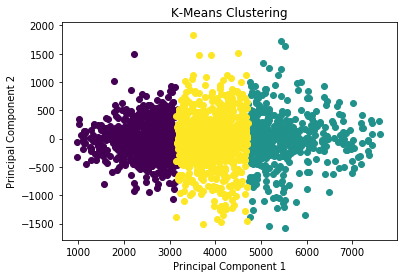

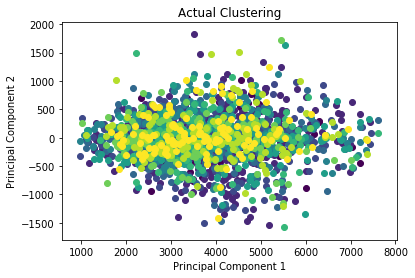

In [9]:
# Project the data onto the 2 primary principal components
p = Plot()
p.plot_in_2d(train_gray, y_pred, title="K-Means Clustering")
p.plot_in_2d(train_gray, y_train, title="Actual Clustering")

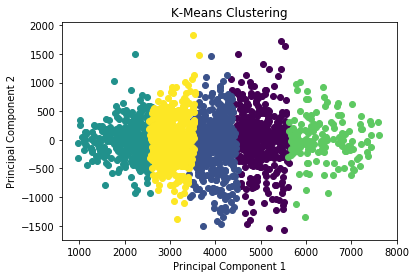

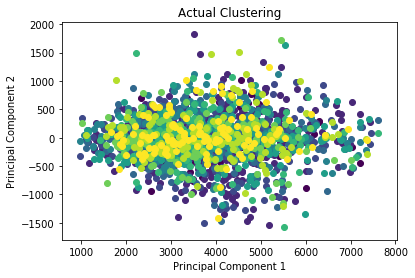

In [11]:
# Cluster the data using K-Means

clf = KMeans(k=5)
# clus = clf._create_clusters(X=train_gray)
# cents = clf._calculate_centroids(clus, X=train_gray)
y_pred = clf.predict(train_gray)

# Project the data onto the 2 primary principal components
p = Plot()
p.plot_in_2d(train_gray, y_pred, title="K-Means Clustering")
p.plot_in_2d(train_gray, y_train, title="Actual Clustering")

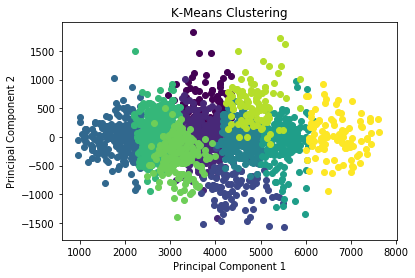

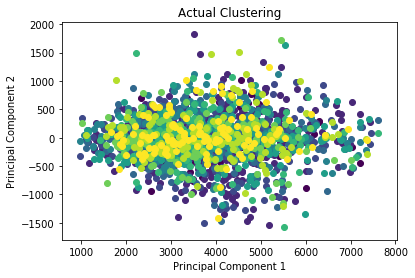

Accuracy: 0.10050000000000003


In [12]:
# Cluster the data using K-Means

clf = KMeans(k=10)
# clus = clf._create_clusters(X=train_gray)
# cents = clf._calculate_centroids(clus, X=train_gray)
y_pred = clf.predict(train_gray)

# Project the data onto the 2 primary principal components
p = Plot()
p.plot_in_2d(train_gray, y_pred, title="K-Means Clustering")
p.plot_in_2d(train_gray, y_train, title="Actual Clustering")

diff = y_pred-y_train
print("Accuracy:",1-np.count_nonzero(diff)/len(diff))

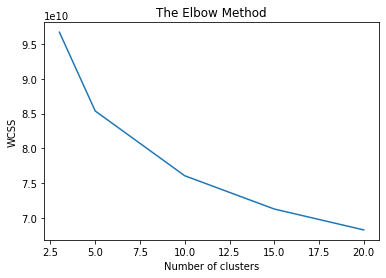

In [15]:
from sklearn.cluster import KMeans
X, y = load_data('SVHN/train_32x32.mat')
X, y = X.transpose((3,0,1,2)), y[:,0]
y[y == 10] = 0
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

X = rgb2gray(X).astype(np.float32)
n1,n2,n3,_=X.shape
X=np.reshape(X,(n1,n2*n3))

wcss = []
idx=[3,5,10,15,20]
for i in idx:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter=10000, random_state = 33)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(idx, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()